In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [105]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [106]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)
pstate = replicate(state)

In [107]:
logging_dir = '../logging/proposals/'
run_name = 'autumn-darkness-67'

In [108]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state,)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [87]:
! ls '../data/tfrecords/'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
metadata.txt		  observations_3.tfrecord  observations_7.tfrecord
observations_10.tfrecord  observations_4.tfrecord  observations_8.tfrecord
observations_1.tfrecord   observations_5.tfrecord  observations_9.tfrecord
observations_2.tfrecord   observations_6.tfrecord


In [6]:
from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord', 
         '../data/tfrecords/observations_5.tfrecord','../data/tfrecords/observations_6.tfrecord','../data/tfrecords/observations_7.tfrecord','../data/tfrecords/observations_8.tfrecord','../data/tfrecords/observations_9.tfrecord']

ds = make_dataloader(files, batch_size=32, seed=42, split='val')
batches = iter(ds)

## Zero-shot classification

In [7]:
import jax.numpy as np

images, captions = next(iter(ds))
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [8]:
from dm_pix import center_crop

images = center_crop(images, 224, 224)
inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")
claude_science_cat = ["star forming galaxies", "lyman alpha", "sfr", "dust", "crowded stellar field", "core-collapse supernova", "cosmology",  "gravitational lensing", "supernovae", "diffuse galaxies", "globular clusters", "stellar populations", "interstellar medium", "black holes", "dark matter", "galaxy clusters", "galaxy evolution", "galaxy formation", "quasars", "circumstellar disks", "exoplanets", "Kuiper Belt objects", "solar system objects", "cosmic web structure", "distant galaxies", "galaxy mergers", "galaxy interactions", "star formation", "stellar winds", "brown dwarfs", "neutron stars", "white dwarfs", "nebulae", "star clusters", "galaxy archeology", "galactic structure", "active galactic nuclei", "gamma-ray bursts", "stellar nurseries", "intergalactic medium", "galaxy clusters", "dark energy", "dwarf galaxies", "barred spiral galaxies", "irregular galaxies", "starburst galaxies", "dwarf galaxies", "low surface brightness galaxies", "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", "cosmic dust", "interstellar chemistry", "star formation histories", "initial mass function", "mass segregation", "stellar proper motions", "binary star systems", "open clusters", "pre-main sequence stars", "protostars", "protoplanetary disks", "jets and outflows", "interstellar shocks", "HII regions", "planetary nebulae", "supernova remnants", "stellar winds", "Wolf–Rayet stars", "OB stars", "red giants", "Cepheid variables", "RR Lyrae variables", "stellar oscillations", "stellar abundances", "stellar rotation", "stellar magnetic fields", "stellar dynamics", "compact stellar remnants", "Einstein rings", "asteroids", "comets", "trans-Neptunian objects", "cosmic microwave background", "reionization epoch", "first stars", "first galaxies", "high-redshift quasars", "primordial black holes", "resolved binaries", "binary stars"]
claude_science_cat_inputs = tokenizer(claude_science_cat, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

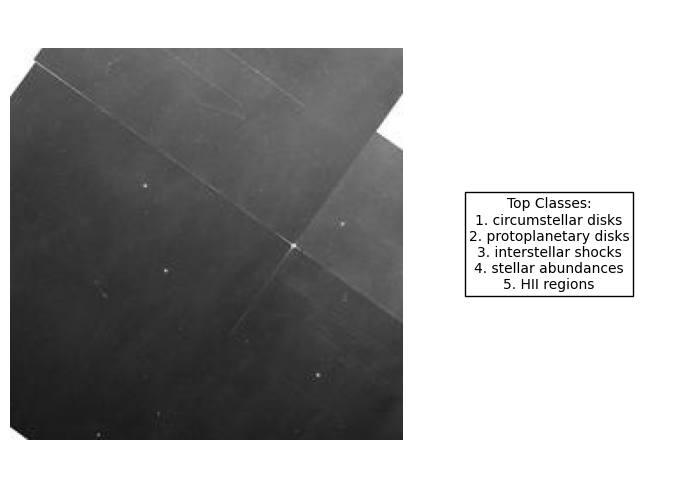

Category: YOUNG STARS AND CIRCUMSTELLAR MATERIAL. STIS provides us with a unique opportunity to study the early evolution of proto-planetary disks and their chances of survival in the harsh irradiated environments of OB associations where most stars form. We seek to test new circumstellar disk photo-erosion models for the Orion Nebula proplyds {proto-planetary disks}, to measure the disk mass loss rates, the nature of their tails, and the high excitation upstream bow shocks {HAlpha + ionO3 arcs}. We will obtain long-slit low dispersion UV spectra to measure the relative intensities of a variety of UV lines that trace the excitation conditions in the circumstellar disk, neutral outflow, and in the ionized zone and to search for OH emission predicted by a recent model of photo-chemical excitation of the 6300Angstrom ionO1 line. We will obtain moderate resolution long slit visible spectra to constrain the sub-arcsecond structure and excitation conditions in the proplyds, search for disk r

In [10]:
idx = 1

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print(captions[idx])

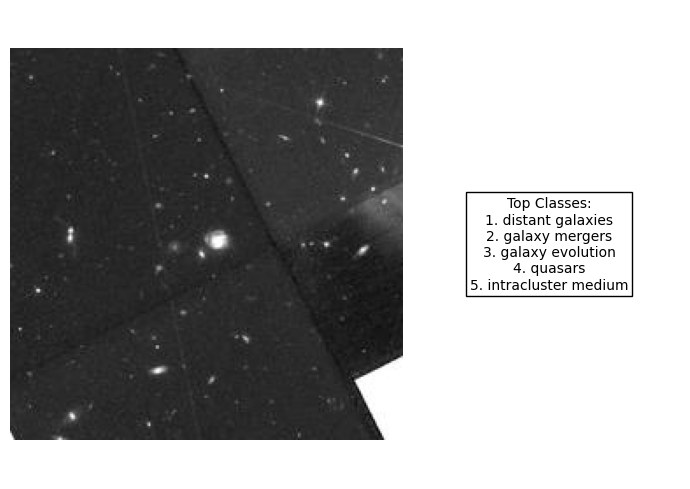

Category: DISTANT GALAXIES. We propose to obtain deep WFPC2 images of a galaxy at z=5.34 and its surrounding field. The galaxy, 0140+326 RD1, was the first spectroscopically confirmed object at z > 5 and among the few confirmed objects at z > 5 currently. Our goals are to {1} map the Ly-alpha line-emitting region, {2} study the restframe UV continuum morphology, {3} search for companion Ly-alpha-emitting sources, and {4} study the stellar population and dust extinction in this distant system in conjunction with recently obtained NICMOS F160W images. If this galaxy is a truly primeval object in the process of forming its first generation of stars, its morphological properties can provide critical information on the earliest phases of galaxy formation. Ongoing, deep, multi-wavelength, ground-based efforts make this an ideal field for HST to underlinesimultaneously provide high-resolution morphological information on several other timely issues in extragalactic astronomy: the proposed WFP

In [12]:
idx = 17

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print(captions[idx])

## Image retrieval

In [109]:
from tqdm.notebook import tqdm

In [110]:
from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord', 
         '../data/tfrecords/observations_5.tfrecord','../data/tfrecords/observations_6.tfrecord','../data/tfrecords/observations_7.tfrecord','../data/tfrecords/observations_8.tfrecord','../data/tfrecords/observations_9.tfrecord']

ds = make_dataloader(files, batch_size=32, seed=42, split='train')
batches = iter(ds)

In [112]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []

for _ in tqdm(range(200)):

    images, captions = next(iter(ds))
    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)


  0%|          | 0/200 [00:00<?, ?it/s]

In [198]:
# ["andromeda m1", "dwarf galaxies and globular clusters", "gravitational lensing", "ISM"]

In [210]:
query = "cosmology"
query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")

text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)

In [211]:
sorted_idxs = np.argsort((np.vstack(image_feat_stack) @ text_feat.T)[:, 0])[::-1]

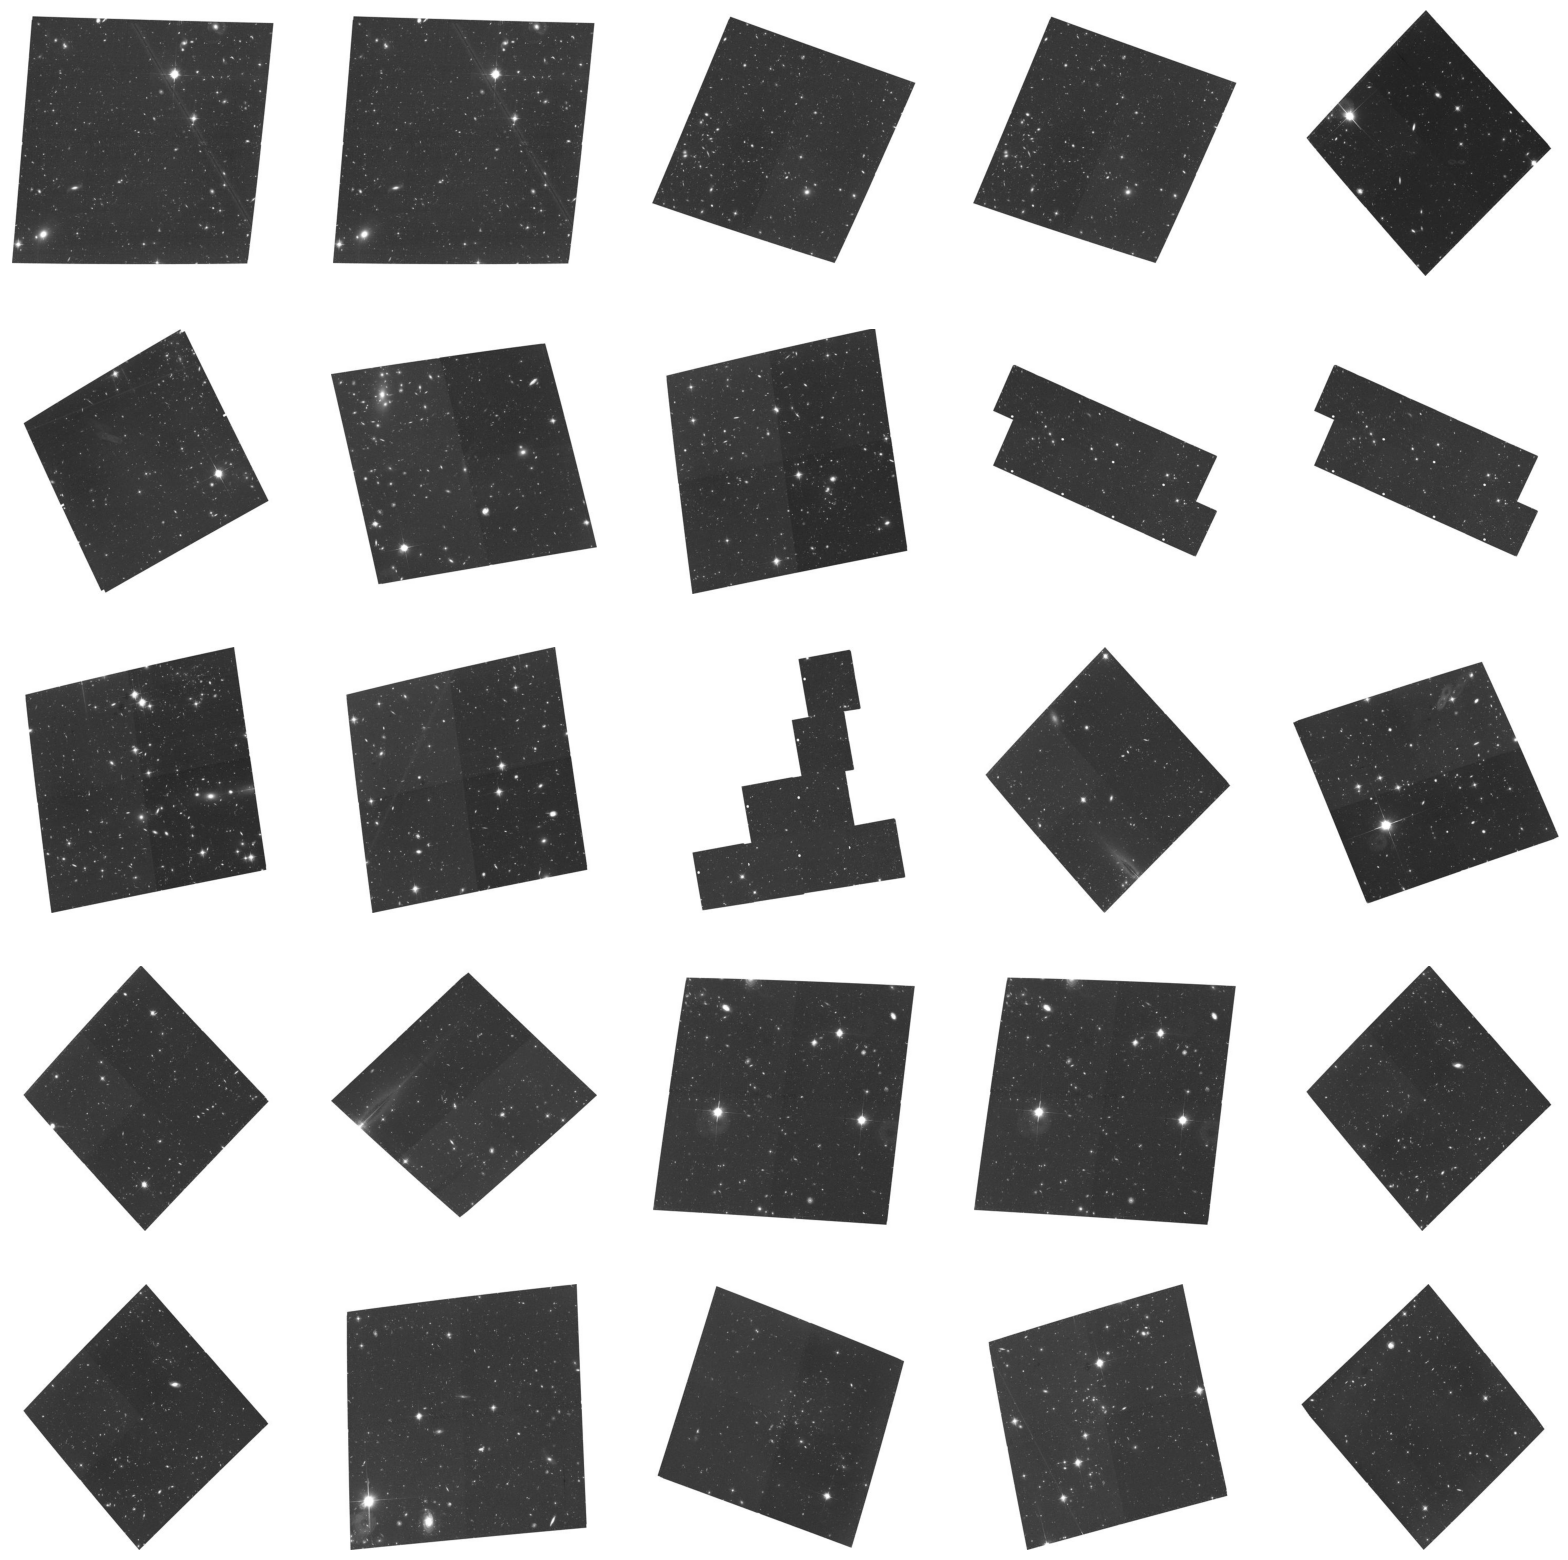

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

grid_size = 5

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(images_stack[sorted_idxs[i] // 32][sorted_idxs[i] % 32], vmin=0, vmax=1)
    plt.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [213]:
[captions_stack[idx] for idx in sorted_idxs][:25]

['Category: Stellar Populations. We request 16 orbits of HST/ACS to obtain imaging in F606W and F814W of Andromeda (And) XIX, a truly unique galaxy. With an effective radius of 3.1 kpc, and a surface brightness of 29.3 mag per square arcsec, it is the only known Local Group analogue of the intriguing newly-discovered ultra diffuse galaxies found at higher redshift. And XIX contains significant substructure, and is one of only 3 low mass galaxies that is known to have prolate rotation. This suggests the possibility that And XIX formed as the result of a merger. Using deep, coordinated parallel HST/ACS and WFC3 imaging, we will efficiently test this formation scenario. Our proposed observations will allow us to measure detailed star formation histories for both the centre of And XIX, and its most significant substructure, the southern clump.  If And XIX has been formed as the result of a merger, we expect to see significant differences between the star formation histories of both fields.